In [1]:
from flakylib import *
import math
import numpy as np
import numba as nb
from numba import prange
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# Generation of Synthetic Dataset (Overlapping Blobs on Regular Grid)

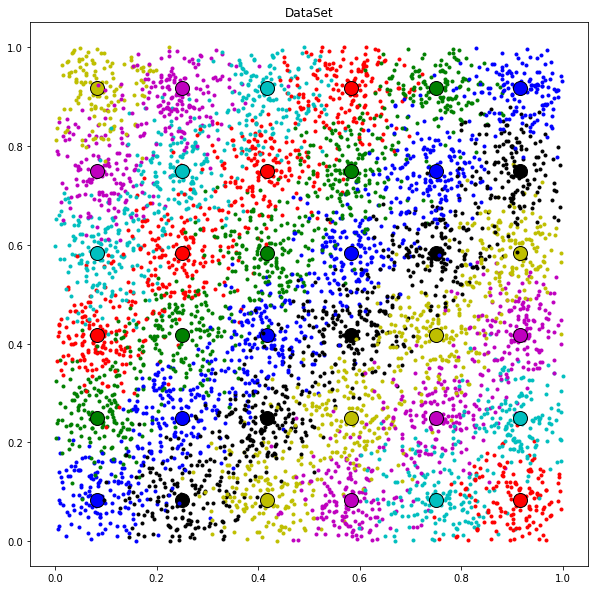

In [2]:
grid_size = 6
n_features = 2
n_samples = 6000
standard_deviation = 0.06
n_candidates = 3
#nb.config.NUMBA_NUM_THREADS = 8 # The number of CPU cores for the parallel processing

samples, true_sample_membership, true_centroids = generate_blobs_on_grid(n_samples, grid_size, n_features, standard_deviation)

if n_features == 2:
    draw_dataset(samples, true_centroids, true_sample_membership)
    
n_samples = samples.shape[0]
n_clusters = true_centroids.shape[0]

sample_weights, sample_membership, sample_objectives, centroids, centroid_sums, centroid_counts, centroid_objectives = empty_state(n_samples, n_features, n_clusters)
   

# Generation of Synthetic Dataset (Random Distributed Blobs)

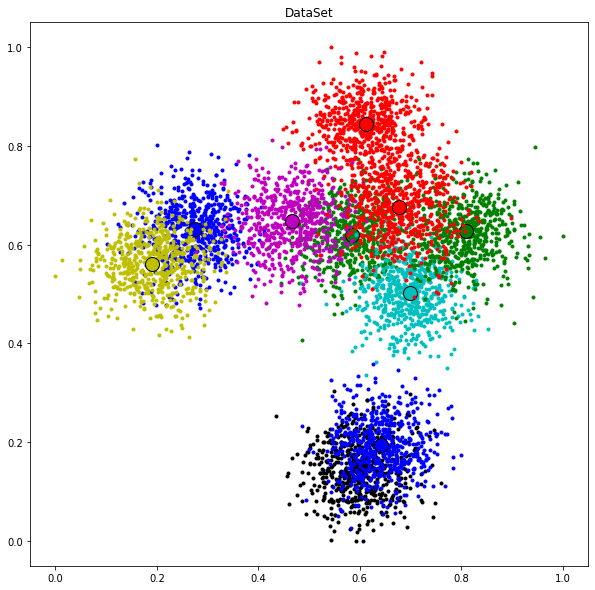

In [3]:
n_features = 2
n_samples = 6000
standard_deviation = 0.07
n_candidates = 3
#nb.config.NUMBA_NUM_THREADS = 8 # The number of CPU cores for the parallel processing
n_cluster = 10

samples, true_centroids, true_sample_membership = gaussian_blobs(n_features, n_samples, n_cluster, standard_deviation)

if n_features == 2:
    draw_dataset(samples, true_centroids, true_sample_membership)
    
n_samples = samples.shape[0]
n_clusters = true_centroids.shape[0]

sample_weights, sample_membership, sample_objectives, centroids, centroid_sums, centroid_counts, centroid_objectives = empty_state(n_samples, n_features, n_clusters)
   



# Generation of Synthetic Dataset (Random Distributed Samples)

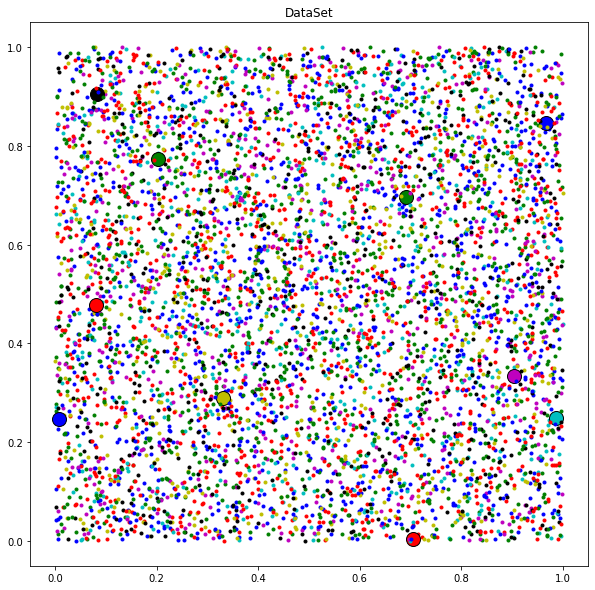

In [4]:
n_features = 2
n_samples = 6000
n_clusters = 10
n_candidates = 3
#nb.config.NUMBA_NUM_THREADS = 8 # The number of CPU cores for the parallel processing

samples = np.random.sample((n_samples,n_features))

true_sample_membership = np.random.randint(n_clusters, size = n_samples)
true_centroids = np.random.sample((n_clusters,n_features))

if n_features == 2:
    draw_dataset(samples, true_centroids, true_sample_membership)
    
sample_weights, sample_membership, sample_objectives, centroids, centroid_sums, centroid_counts, centroid_objectives = empty_state(n_samples, n_features, n_clusters)
 

# Initialization by True Centroids

In [13]:
%%time

centroids = np.copy(true_centroids)

objective, n_changed_membership = assignment_parallel(samples, sample_weights, sample_membership, sample_objectives, centroids, centroid_objectives)

print('Objective', objective)
print('')

Objective 23.34007126425463

CPU times: user 0 ns, sys: 4 ms, total: 4 ms
Wall time: 1.28 ms


# Initialization by Random Centroids

In [14]:
%%time

centroids = np.random.rand(n_clusters, n_features)

objective, n_changed_membership = assignment_parallel(samples, sample_weights, sample_membership, sample_objectives, centroids, centroid_objectives)

print('Objective', objective)
print('')


Objective 59.0700051310224

CPU times: user 4 ms, sys: 0 ns, total: 4 ms
Wall time: 1.48 ms


# Initialization by K-Means++

In [15]:
%%time

centroids = samples[k_means_pp(samples, sample_weights, n_clusters, n_candidates)]
centroids_copy = np.copy(centroids)

objective, n_changed_membership = assignment_parallel(samples, sample_weights, sample_membership, sample_objectives, centroids, centroid_objectives)

print('Objective', objective)
print('')

Objective 34.58087184393922

CPU times: user 52 ms, sys: 28 ms, total: 80 ms
Wall time: 24.1 ms


# K-Means initialized by True Centroids

In [17]:
%%time

centroids = np.copy(true_centroids)

max_iters = 300
tol=0.000001

objective, n_iters = k_means(samples, sample_weights, sample_membership, sample_objectives, centroids, centroid_sums, centroid_counts, centroid_objectives, max_iters, tol, True)

print('Objective:', objective)
print('Iterations:',n_iters)
print('Clusters:',np.sum(centroid_counts > 0.0))
print('')

Objective: 22.91147644536123
Iterations: 21
Clusters: 36

CPU times: user 56 ms, sys: 8 ms, total: 64 ms
Wall time: 15 ms


# K-Means initialized by K-Means++ with sample_objectives as weights

In [18]:
new_sample_weights = 1-normalization(sample_objectives)
center_inds = k_means_pp(samples, new_sample_weights, n_clusters, n_candidates)
centroids = samples[center_inds]

max_iters = 300
tol=0.000001

objective, n_iters = k_means(samples, sample_weights, sample_membership, sample_objectives, centroids, centroid_sums, centroid_counts, centroid_objectives, max_iters, tol, True)

print('Objective:', objective)
print('Iterations:',n_iters)
print('Clusters:',np.sum(centroid_counts > 0.0))
print('')

Objective: 23.907210388230308
Iterations: 35
Clusters: 36



# K-Means initialized by Random Centroids

In [19]:
%%time

centroids = np.random.rand(n_clusters, n_features)

max_iters = 300
tol=0.000001

objective, n_iters = k_means(samples, sample_weights, sample_membership, sample_objectives, centroids, centroid_sums, centroid_counts, centroid_objectives, max_iters, tol, True)

print('Objective:', objective)
print('Iterations:',n_iters)
print('Clusters:',np.sum(centroid_counts > 0.0))
print('')

Objective: 24.771232494005186
Iterations: 36
Clusters: 36

CPU times: user 84 ms, sys: 16 ms, total: 100 ms
Wall time: 25.2 ms


# K-Means initialized by K-Means++

In [20]:
%%time

centroids = samples[k_means_pp(samples, sample_weights, n_clusters, n_candidates)]

max_iters = 300
tol=0.000001

objective, n_iters = k_means(samples, sample_weights, sample_membership, sample_objectives, centroids, centroid_sums, centroid_counts, centroid_objectives, max_iters, tol, True)

print('Objective:', objective)
print('Iterations:',n_iters)
print('Clusters:',np.sum(centroid_counts > 0.0))
print('')

Objective: 23.335636028911278
Iterations: 41
Clusters: 36

CPU times: user 156 ms, sys: 20 ms, total: 176 ms
Wall time: 47.9 ms


# K-Means initialized by K-Means++ (sklearn)

In [22]:
%%time

# MiniBatchKMeans(KMeans) in SKLEARN ????!!!!

km = KMeans(n_clusters=n_clusters, init = 'k-means++', algorithm = 'full', n_init=1)
#km = KMeans(n_clusters=n_clusters, init = 'random', n_init=1, n_jobs=1)
km = km.fit(samples)

print('Objective:', -km.score(samples))
print('Iterations:',km.n_iter_)

Objective: 22.930267403202034
Iterations: 44
CPU times: user 372 ms, sys: 36 ms, total: 408 ms
Wall time: 108 ms


# H-Means (first-improvement strategy) initialized by True Centroids

In [24]:
%%time

centroids = np.copy(true_centroids)

h_max_iters = 30000
h_tol=0.00000001

objective, n_changed_membership = assignment_parallel(samples, sample_weights, sample_membership, sample_objectives, centroids, centroid_objectives)

objective = initialize_by_membership(samples, sample_weights, sample_membership, sample_objectives, centroids, centroid_sums, centroid_counts, centroid_objectives)

objective, n_iters = h_means_first(samples, sample_weights, sample_membership, centroids, centroid_sums, centroid_counts, centroid_objectives, objective, h_max_iters, h_tol)

print('Objective:', objective)
print('Iterations:',n_iters)
print('Clusters:',np.sum(centroid_counts > 0.0))
print('')

Objective: 22.90579291171318
Iterations: 16
Clusters: 36

CPU times: user 116 ms, sys: 0 ns, total: 116 ms
Wall time: 111 ms


# H-Means (first-improvement strategy) initialized by K-Means++

In [28]:
%%time

centroids = np.copy(centroids_copy)

h_max_iters = 30000
h_tol=0.00000001

objective, n_changed_membership = assignment_parallel(samples, sample_weights, sample_membership, sample_objectives, centroids, centroid_objectives)

objective = initialize_by_membership(samples, sample_weights, sample_membership, sample_objectives, centroids, centroid_sums, centroid_counts, centroid_objectives)

objective, n_iters = h_means_first(samples, sample_weights, sample_membership, centroids, centroid_sums, centroid_counts, centroid_objectives, objective, h_max_iters, h_tol)

print('Objective:', objective)
print('Iterations:',n_iters)
print('Clusters:',np.sum(centroid_counts > 0.0))
print('')

Objective: 23.65706409764258
Iterations: 32
Clusters: 36

CPU times: user 228 ms, sys: 4 ms, total: 232 ms
Wall time: 231 ms


# H-Means initialized by Random Membership Distribution

In [27]:
%%time

centroids = np.copy(centroids_copy)

h_max_iters = 30000
h_tol=0.00000001

random_membership(n_samples, n_clusters, sample_membership)

objective = initialize_by_membership(samples, sample_weights, sample_membership, sample_objectives, centroids, centroid_sums, centroid_counts, centroid_objectives)

objective, n_iters = h_means_first(samples, sample_weights, sample_membership, centroids, centroid_sums, centroid_counts, centroid_objectives, objective, h_max_iters, h_tol)

print('Objective:', objective)
print('Iterations:',n_iters)
print('Clusters:',np.sum(centroid_counts > 0.0))
print('')

Objective: 23.40605802231754
Iterations: 35
Clusters: 36

CPU times: user 236 ms, sys: 8 ms, total: 244 ms
Wall time: 240 ms


# K-H-Means initialized by True Centroids

In [30]:
%%time

centroids = np.copy(true_centroids)

k_max_iters = 30000
h_max_iters = 30000
k_tol=0.00000001
h_tol=0.00000001

objective, n_iters = k_h_means(samples, sample_weights, sample_membership, sample_objectives, centroids, centroid_sums, centroid_counts, centroid_objectives, k_max_iters, h_max_iters, k_tol, h_tol)

print('Objective:', objective)
print('Iterations:',n_iters)
print('Clusters:',np.sum(centroid_counts > 0.0))
print('')

Objective: 22.909468599963127
Iterations: 26
Clusters: 36

CPU times: user 96 ms, sys: 4 ms, total: 100 ms
Wall time: 48.8 ms


# K-H-Means initialized by K-Means++

In [32]:
%%time

centroids = np.copy(centroids_copy)

k_max_iters = 30000
h_max_iters = 30000
k_tol=0.00000001
h_tol=0.00000001


objective, n_iters = k_h_means(samples, sample_weights, sample_membership, sample_objectives, centroids, centroid_sums, centroid_counts, centroid_objectives, k_max_iters, h_max_iters, k_tol, h_tol)

print('Objective:', objective)
print('Iterations:',n_iters)
print('Clusters:',np.sum(centroid_counts > 0.0))
print('')

Objective: 24.037446564972186
Iterations: 46
Clusters: 36

CPU times: user 196 ms, sys: 8 ms, total: 204 ms
Wall time: 140 ms


# Simple Membership Shaking VNS

In [34]:
%%time

max_cpu_time = 10 # seconds
max_iters = 3000 # maximun number of iterations inside VNS

kmax = 3
h_max_iters = 300
k_max_iters = 300
h_tol = 0.05
k_tol = 0.0001


#Initialization

centroids = samples[k_means_pp(samples, sample_weights, n_clusters, n_candidates)]
objective, n_local_iters = k_h_means(samples, sample_weights, sample_membership, sample_objectives, centroids, centroid_sums, centroid_counts, centroid_objectives, k_max_iters, h_max_iters, k_tol, h_tol)

print('Objective:', objective)
print('Iterations:',n_local_iters)
print('Clusters:',np.sum(centroid_counts > 0.0))
print('')

#Glogal search

objective, n_iters = Membership_Shaking_VNS(samples, sample_weights, sample_membership, sample_objectives, centroids, centroid_sums, centroid_counts, centroid_objectives, objective, k_max_iters, h_max_iters, k_tol, h_tol, kmax, max_cpu_time, max_iters, True)

print('')
print('Final objective:', objective)
print('Total number of iterations:', n_iters)
print('Clusters:',np.sum(centroid_counts > 0.0))
print('')

Objective: 23.321990407129977
Iterations: 40
Clusters: 36

23.320982577325662 1
23.320157330210048 1
23.319957537249902 1
23.319819217521534 1
23.319803160242728 2
23.31921195645596 1
23.318850553148284 1
23.31885055314828 1
23.318199871634324 3
23.317918580833283 1
23.31791478432101 1
23.31783246034785 2
23.317832460347848 1
23.317832460347844 1
23.317508943539544 2
23.317248984364674 2
23.317229961040812 1
23.31722996104081 3
23.31722996104081

Final objective: 23.31722996104081
Total number of iterations: 1139
Clusters: 36

CPU times: user 15.8 s, sys: 1.37 s, total: 17.1 s
Wall time: 10.1 s


# Solution Visualization

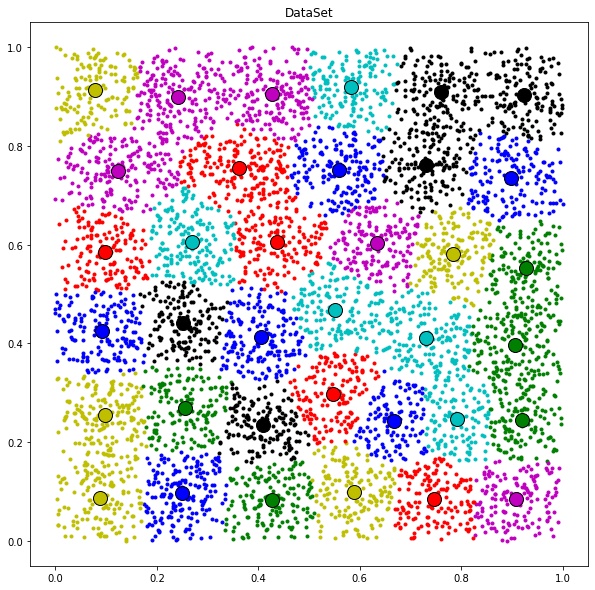

In [35]:
draw_dataset(samples, centroids, sample_membership)

# Local Search by Iteratively New Extra Center Insertion, Searching and Worst Centroid Deletion

In [4]:
%%time

# k_max_iters = 50
# k_tol=0.01
k_max_iters = 300
k_tol=0.0001

max_cpu_time = 10 # seconds
max_iters = 600000
tol=0.000000000000001

#Initialization

centroids = samples[k_means_pp(samples, sample_weights, n_clusters, n_candidates)]
objective, n_iters = k_means(samples, sample_weights, sample_membership, sample_objectives, centroids, centroid_sums, centroid_counts, centroid_objectives, k_max_iters, k_tol, True)

print('Objective:', objective)
print('Iterations:',n_iters)
print('Clusters:',np.sum(centroid_counts > 0.0))
print('')

# Search

objective, n_iters, n_k_iters = iterative_extra_center_insertion_deletion(samples, sample_weights, sample_membership, sample_objectives, centroids, centroid_sums, centroid_counts, centroid_objectives, objective, k_max_iters, k_tol, max_iters, tol, max_cpu_time, n_candidates, True)
                                
print('')
print('Objective:', objective)
print('Global Iterations:',n_iters)
print('Local Iterations:',n_k_iters)
print('Clusters:',np.sum(centroid_counts > 0.0))
print('')

Objective: 23.405739239271824
Iterations: 23
Clusters: 36

23.40228670285186
23.312124695077454
23.2399724290282
23.229990603128027
23.147802870064076
23.019546183922067
22.89582318261917
22.824618539743785
22.816395442360324
22.81245330313047
22.809860461149558
22.809860461149558

Objective: 22.809860461149558
Global Iterations: 352
Local Iterations: 18
Clusters: 36

CPU times: user 1min 9s, sys: 8.37 s, total: 1min 18s
Wall time: 10.1 s


# Solution Visualization

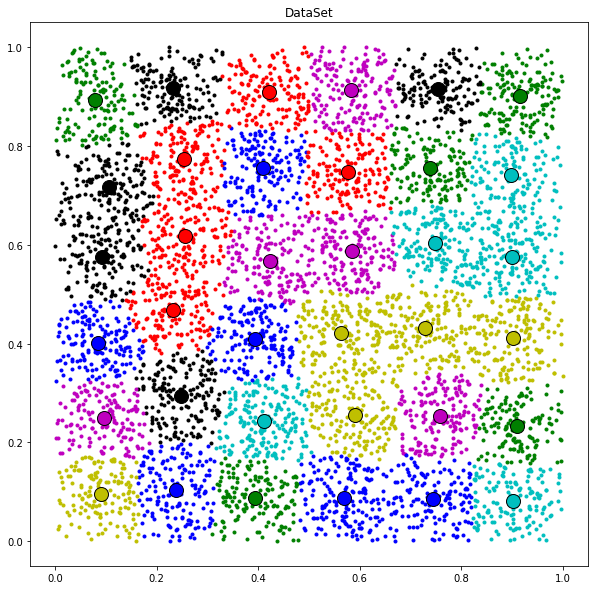

In [5]:
draw_dataset(samples, centroids, sample_membership)

# Center Shaking VNS

In [7]:
%%time

kmax = 5

local_max_iters = 300
local_tol=0.0001

max_cpu_time = 10 # seconds
max_iters = 600000
tol=0.000000000000001

#Initialization

centroids = samples[k_means_pp(samples, sample_weights, n_clusters, n_candidates)]
objective, n_local_iters = k_means(samples, sample_weights, sample_membership, sample_objectives, centroids, centroid_sums, centroid_counts, centroid_objectives, local_max_iters, local_tol, True)

print('Objective:', objective)
print('Iterations:',n_local_iters)
print('Clusters:',np.sum(centroid_counts > 0.0))
print('')

# Global Search

objective, n_iters, n_local_iters = Center_Shaking_VNS(samples, sample_weights, sample_membership, sample_objectives, centroids, centroid_sums, centroid_counts, centroid_objectives, objective, local_max_iters, local_tol, kmax, max_cpu_time, max_iters, n_candidates, True)

print('')
print('Objective:', objective)
print('Global Iterations:',n_iters)
print('Local Iterations:',n_local_iters)
print('Clusters:',np.sum(centroid_counts > 0.0))
print('')

Objective: 24.242264106088772
Iterations: 38
Clusters: 36

23.97780148482893 1
23.729262421982046 1
23.455462203696325 2
23.17219464935045 3
23.14125010369094 1
22.828779491752197 1
22.814203376345663 1
22.8089164975885 1
22.80596797187758 1
22.801491528665633 1
22.801491528665633

Objective: 22.801491528665633
Global Iterations: 380
Local Iterations: 9
Clusters: 36

CPU times: user 1min 8s, sys: 10.5 s, total: 1min 19s
Wall time: 10.1 s


# Solution Visualization

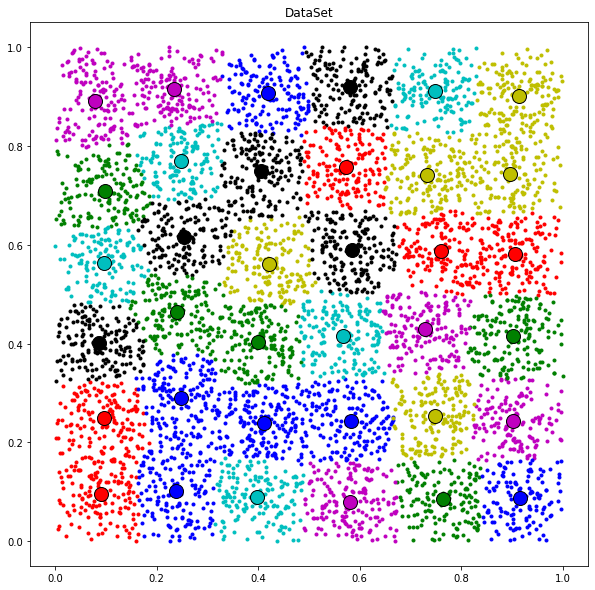

In [8]:
draw_dataset(samples, centroids, sample_membership)

# Sequencing of Different Methods

In [10]:
%%time

printing=True
local_max_iters=300
local_tol=0.0001
n_candidates=3
kmax = 5
max_iters = 3000
max_cpu_time = 3 # seconds


method_sequence = np.array([0, 4, 5, 4, 5, 3])
time_sequence = np.full(method_sequence.shape[0],max_cpu_time)
max_iters_sequence = np.full(method_sequence.shape[0],max_iters)
#kmax_sequence = np.full(method_sequence.shape[0],kmax)
kmax_sequence = np.array([5,5,5,5,15,5])

centroids = samples[k_means_pp(samples, sample_weights, n_clusters, n_candidates)]

objective = method_sequencing(samples, sample_weights, sample_membership, sample_objectives, centroids, centroid_sums, centroid_counts, centroid_objectives, np.inf, method_sequence, time_sequence, max_iters_sequence, kmax_sequence, local_max_iters, local_tol, n_candidates, printing)

K-means:
23.23362466769213

Center Shaking VNS:
23.129234434852727 2
23.09682949481891 1
22.848856752970566 1
22.82606792888753 1
22.80979394580861 3
22.80807356423589 2
22.80511951874155 1
22.80402271633073 3
22.80402271633073

Membership Shaking VNS:
22.80264707213911 1
22.8025105132036 1
22.80250826490268 1
22.80236542435761 2
22.802365424357607 5
22.802308232145805 4
22.801699948629036 1
22.801571865565837 3
22.801554220119378 2
22.80111281208261 3
22.800045043937686 1
22.7996707861105 1
22.799670786110493 2
22.799646127708503 1
22.7996461277085 3
22.79957109589157 3
22.799195262049686 1
22.79919526204968 1
22.799181095542078 4
22.799181095542075 1
22.79918109554207 2
22.799017505275597 3
22.798905448829316 1
22.798905448829313 1
22.7981391494897 5
22.798081515881492 1
22.798047821071584 1
22.797955511797827 1
22.797955511797827

Center Shaking VNS:
22.797955511797827

Membership Shaking VNS:
22.79795551179782 13
22.79795551179782

K-H-means:
22.797955511797827

CPU times: user 53.

# Solution Visualization

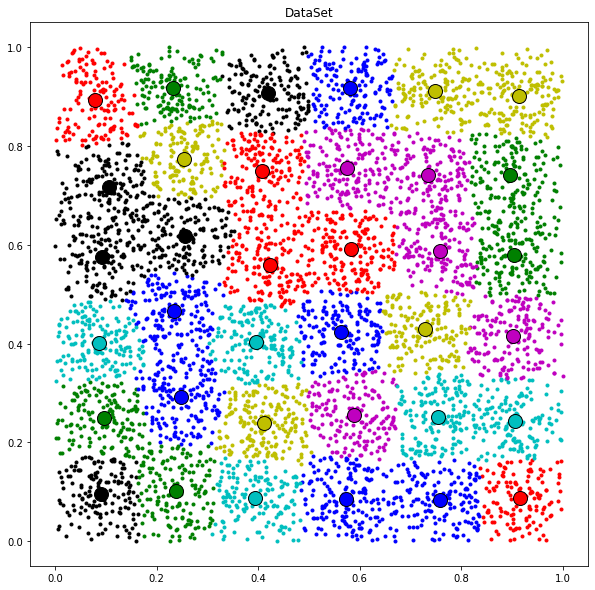

In [11]:
draw_dataset(samples, centroids, sample_membership)

# VNS based Decomposition/Aggregation Minimum Sum-Of-Squares Clustering

In [14]:
%%time

portion_size = 1000
n_portions = 5
init_method = 1
local_max_iters = 300
local_tol = 0.0001
max_cpu_time = 3
max_iters = 3000000
n_candidates = 6
aggregation_method = 1
basis_n_init = 3


# method_sequence = np.array([0, 4, 5, 4, 5, 3])
# kmax_sequence = np.array([0,5,5,5,15,0])
# time_sequence = np.full(method_sequence.shape[0],max_cpu_time)
# max_iters_sequence = np.full(method_sequence.shape[0],max_iters)

method_sequence = np.array([4])
kmax_sequence = np.array([5])
time_sequence = np.full(method_sequence.shape[0],max_cpu_time)
max_iters_sequence = np.full(method_sequence.shape[0],max_iters)


objective, sample_membership, sample_objectives, centroids, centroid_sums, centroid_counts, centroid_objectives = decomposition_aggregation_mssc(samples, sample_weights, method_sequence, time_sequence, max_iters_sequence, kmax_sequence, n_clusters, portion_size, n_portions, init_method, local_max_iters, local_tol, n_candidates, aggregation_method, basis_n_init)



CPU times: user 50 s, sys: 17.1 s, total: 1min 7s
Wall time: 9.05 s


In [15]:
objective

22.843532786034743